# Classifying defaults using transaction data

## Outline
1. Data validation
1. Feature engineering @ transaction level
1. Visualisation of variables/KPIs @ company level
1. Modelling/Classification

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from functools import reduce
from scipy import stats
from statistics import mode 
import inspect
from custom_functions import *

In [3]:
transactions = pd.read_csv("case_data_2020-12-09.csv") 
transactions.head()

,company_segment,company_age_segment,bad,user_id,transaction_amt,remaining_transaction_amt,trans_initiated_date,trans_delivery_date,trans_created_date,trans_payment_due_date,trans_payment_date,receiver_not_company,customer_system_receiver_id,customer_receiver_id,transaction_id
0,d,old,0.0,39447,21313.0,0.0,2016-02-09,2016-03-28,2016-03-28,2016-03-11,2016-02-15,False,34428773.0,2836047,318072314.0
1,d,old,0.0,39447,120000.0,0.0,2016-03-21,NaN,2016-03-29,2016-04-20,2016-05-08,False,38835715.0,2836047,246241747.0
2,d,old,0.0,39447,52000.0,0.0,2016-02-15,NaN,2016-03-27,2016-03-17,2016-02-15,False,38835715.0,2836047,484971796.0
3,d,old,0.0,39447,160000.0,0.0,2016-02-23,NaN,2016-03-29,2016-03-25,2016-02-24,False,38835715.0,2836047,312692849.0
4,d,old,0.0,39447,6506.0,0.0,2016-02-11,NaN,2016-03-27,2016-03-13,2016-02-19,True,19762963.0,2836047,291664948.0


## Data validation
It seems like there are no transactions at two levels (~ 5-6k & 11-12k).

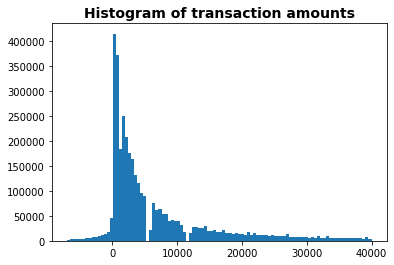

In [4]:
plt.hist(transactions[(transactions['transaction_amt']<40000) & (transactions['transaction_amt']>-7000)]['transaction_amt'], bins=100)
plt.title('Histogram of transaction amounts', fontweight='bold', fontsize=14)
plt.show()

Identify disproportionately represented receiver. It seems a single customer is involved in 1/4 of all transactions! It might make sense to examine if these transactions differ from others.

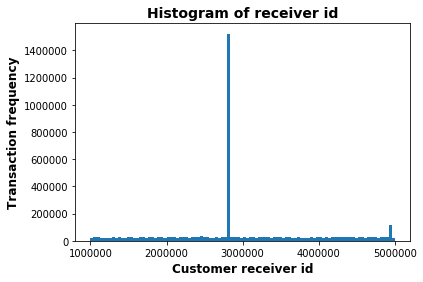

In [5]:
plt.hist(transactions['customer_receiver_id'], bins=100)
plt.title('Histogram of receiver id', fontweight='bold', fontsize=14)
plt.ylabel('Transaction frequency', fontweight='bold',fontsize=12)
plt.xlabel('Customer receiver id', fontweight='bold',fontsize=12)
plt.xticks([1000000, 2000000, 3000000, 4000000, 5000000])
plt.show()

Check that static company variables are static for "key". With this function we can make sure that cases (key) have distinct characteristics (variable).

In [48]:
is_static(transactions, key = 'user_id', variable = 'bad')

'bad is static for user_id: True'

## Feature engineering
### Payment delay variable
$$\texttt{pay_delay} :=\textrm{Number of days between}\:\:\texttt{payment_date}\:\:\textrm{and}\:\:\texttt{due_date}$$

This variable has a non-negligible rate of missingness, along with $\texttt{trans_delivery_date}$.


In [7]:
transactions['pay_delay'] = (pd.to_datetime(transactions['trans_payment_date'])-pd.to_datetime(transactions['trans_payment_due_date'])).astype('timedelta64[D]') # calculate payment delay for each transaction and convert to float
print('Missing values: \n' + str(transactions.isnull().sum()))

Missing values: 
company_segment                     0
company_age_segment                 0
bad                                 0
user_id                             0
transaction_amt                     0
remaining_transaction_amt           0
trans_initiated_date                0
trans_delivery_date            752013
trans_created_date                  0
trans_payment_due_date              1
trans_payment_date             381472
receiver_not_company                0
customer_system_receiver_id         0
customer_receiver_id                0
transaction_id                      0
pay_delay                      381473
dtype: int64


It seems the $\texttt{pay_delay}$ variable has some unreasonable outliers. We might want to consider a maximum number of days for lateness and treat delayed payments > 150 days for example as contested, or erroneously entered dates. Also, it might make sense to only consider positive delays, and set the negative delays (early payments) to zero.

In [8]:
stats.describe(transactions[~np.isnan(transactions['pay_delay'])]['pay_delay']) # get descriptive statistics, ignoring NaNs

DescribeResult(nobs=3759194, minmax=(-36531.0, 2305.0), mean=7.533465152370428, variance=5336.877052206926, skewness=-146.04740927796774, kurtosis=71167.84606653173)

### Partial, Contested (Late)-variable
$\texttt{PCL}$ (partial, contested, late) to handle partial transactions (and possibly very long delays)
$$PCL := \mathbb{1}\{\texttt{pay_delay} = NaN | \texttt{remaining_amt} \neq 0\}$$

In [9]:
transactions['PCL'] = 0
transactions.loc[np.isnan(transactions['pay_delay']),'PCL'] = 1
transactions.loc[transactions['remaining_transaction_amt'] != 0, 'PCL'] = 1

### Relative cashflow (CF/CAPEX)
Prepare calculation by creating two new columns: $$\texttt{CF}\:\: := \:\: \sum \textrm{positive transactions} + \sum\textrm{negative transactions where}\:\: \texttt{receiver_not_company}\:\: =\:\: 1$$ 

$$\texttt{CAPEX}\:\: :=\:\: \sum\textrm{negative transactions where}\:\: \texttt{receiver_not_company}\:\: =\:\: 0$$

In [10]:
transactions['cf'] = 0
transactions['capex'] = 0
# create mask for cash flow transactions 
cf_mask = (transactions['remaining_transaction_amt'] == 0) & ((transactions['transaction_amt'] > 0) | (transactions['receiver_not_company'] == 1))
# create cash flow column
transactions.loc[cf_mask,'cf'] = transactions.loc[cf_mask,'transaction_amt']
# create mask for capEX transactions
capex_mask = (transactions['transaction_amt']<0) & (transactions['receiver_not_company'] == 0)
# create CapEX column
transactions.loc[capex_mask,'capex'] = transactions.loc[capex_mask,'transaction_amt']

### Number of recorded transaction
Create a column of ones that will become $\texttt{num_transactions}$ when summed in over $\texttt{user_id}$.

In [11]:
transactions['num_transactions'] = 1

### Likelihood ratio test for FSD of transaction amounts
The idea here is to test Benfords law goodness of fit of the FSD of transaction amounts. Perhaps cheating companies are more likely to default? 


Implementation:

```python
def fraud_LR(x):
    x     = np.abs(x) #take absolute value to make sure F doesnt contain "-"
    F     = [int(str(i)[0]) for i in x] # construct list of first significant digits (FSDs)
    F     = sorted(Counter(list(filter(lambda dig: dig != 0, F))).most_common(9)) #filter zeros and count occurences .most_common(n) returns ordered tuples and sorted sorts lexicografically
    n     = sum(i for _ , i in F)   #get number of transactions       
    P_hat = [f/n for _ , f in F]  #get frequency of FSDs
    P     = [np.log10(1+1/d) for d in range(1,10)]  #calc. distribution fcn. of Benfords law
    LR    = 2*n*sum([p_hat*np.log(p_hat/p) for p_hat , p in list(zip(P_hat, P))]) # Calculate 2 ln Lambda .~ Chisq(8)
    return LR
```

The function **fraud_LR** is used as *aggfunc* in **pd.pivot_table** to calculate a likelihood ratio for each $\texttt{user_id}$.

### Standardized Payment delay trend
The key idea here is that bad companies we not bad when the transactions were recorded in the system.
This variable captures the temporal structure of payment delays over the differently sized observation periods by standardizing
time $$d_1,...,d_n \rightarrow [0, 1],$$ 
standardizing the payment delays to have zero mean and unit variance for each $\texttt{user_id}$, and fitting a linear trend to the transformed observation. The implementation takes a dataframe of transactions and returns a dataframe of standardized trends, indexed by $\texttt{user_id}$. The calculation is repeated for credits, debits and all transactions.

```python
def pay_delay_trend(df, transaction_type):
    OUT = pd.DataFrame(columns = ('user_id', str(transaction_type) + '_delay_trend'))
    OUT['user_id'] = df['user_id'].unique()
    for user in OUT['user_id']: # Loop over unique user_id's
        try:
            # if-fork for the cases credit, debit and both (default) 
            if transaction_type == 'credit':
                delays = df[(df['user_id'] == user) & (df['remaining_transaction_amt'] == 0) & (df['transaction_amt'] < 0)][['trans_payment_due_date', 'pay_delay']].sort_values(by = 'trans_payment_due_date').dropna() # get due_dates and pay_delays for user 
            elif transaction_type == 'debit':
                delays = df[(df['user_id'] == user) & (df['remaining_transaction_amt'] == 0) & (df['transaction_amt'] > 0)][['trans_payment_due_date', 'pay_delay']].sort_values(by = 'trans_payment_due_date').dropna() # get due_dates and pay_delays for user 
            else:
                delays = df[(df['user_id'] == user) & (df['remaining_transaction_amt'] == 0)][['trans_payment_due_date', 'pay_delay']].sort_values(by = 'trans_payment_due_date').dropna() # get due_dates and pay_delays for user 
            delays['reltime'] = (pd.to_datetime(delays['trans_payment_due_date'])-np.min(pd.to_datetime(delays['trans_payment_due_date']))).astype('timedelta64[D]') # calculate number of days since first obs
            delays['reltime'] = delays['reltime']/np.max(delays['reltime']) # standardize time
            delays = delays.groupby('reltime')['pay_delay'].mean() # take mean of delays with the same time stamp
            delays = (delays-delays.mean())/delays.std() # standardize delays
            OUT.loc[OUT['user_id'] == user,str(transaction_type) + '_delay_trend'] = np.polyfit(delays.index, delays, 1)[0] # return the first order term. Note: [1] is the intercept!  
        except np.linalg.LinAlgError as e: # This code checks whether the thrown error is related to degenerate SVD
            if 'Singular matrix' in str(e):
                OUT.loc[OUT['user_id'] == user,str(transaction_type) + '_delay_trend'] = 0 # Define slope of point to be zero
        except:
            OUT.loc[OUT['user_id'] == user,str(transaction_type) + '_delay_trend'] = np.nan # return nan if e.g. no completed transactions
    return OUT
```

## Visualisation of variables/KPIs at company level
### Convert panel data to cross-sectional data using pd.pivot_table
The aggregating functions are mostly self explanatory. Some are custom functions defined in custom_functions.py.

In [12]:
companies = pd.pivot_table(transactions, values=['bad','cf','capex','company_segment','company_age_segment',
                                     'trans_initiated_date', 'pay_delay', 'num_transactions', 
                                     'transaction_amt', 'receiver_not_company', 'PCL', 'customer_receiver_id'], 
                           index='user_id',
                           aggfunc={'bad': pivot_static, # pivot static checks whether the variable is static for the key
                                    'cf': np.sum,
                                    'capex': np.sum,
                                    'company_segment': pivot_static,
                                    'company_age_segment': pivot_static,
                                    'trans_initiated_date': daterange, # gives the number of days between first and last initiated transaction
                                    'pay_delay': np.mean,
                                    'num_transactions': np.sum, # sums the column of ones to give a total number of transactions variable
                                    'transaction_amt': [np.mean, fraud_LR], # transaction amount is aggregated using both mean and the fraud diagnostic
                                    'receiver_not_company': np.mean, 
                                    'PCL': np.mean,
                                    'customer_receiver_id':lambda x: len(x.unique())}) # gives the number of unique receiver_id's for each user_id. Perhaps use system_receiver_id instead as |{system_receiver_id}| > |{receiver_id}|

Calculate CF/CAPEX variable:

In [13]:
companies['cf/capex'] = companies[('cf', 'sum')]/abs(companies[('capex', 'sum')])

Replace infinite values with NaN. This causes a lot of missingness.

In [17]:
companies['cf/capex'] = companies['cf/capex'].replace([np.inf, -np.inf], np.nan)
print('Proportion of missing values: \n'  + str(round(companies.isnull().sum()*100/len(companies), 1)))

Proportion of missing values: 
PCL                   mean             0.0
bad                   pivot_static     0.0
capex                 sum              0.0
cf                    sum              0.0
company_age_segment   pivot_static     0.0
company_segment       pivot_static     0.0
customer_receiver_id  <lambda>         0.0
num_transactions      sum              0.0
pay_delay             mean             4.6
receiver_not_company  mean             0.0
trans_initiated_date  daterange        0.0
transaction_amt       fraud_LR         0.0
                      mean             0.0
cf/capex                              29.9
dtype: float64


Is there another way to define the variable? Relative cash flow seems like a good predictor of default:

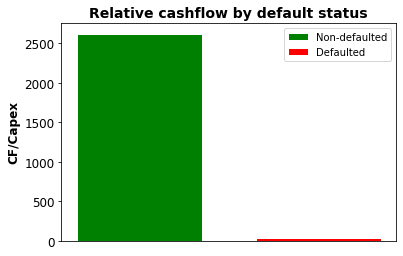

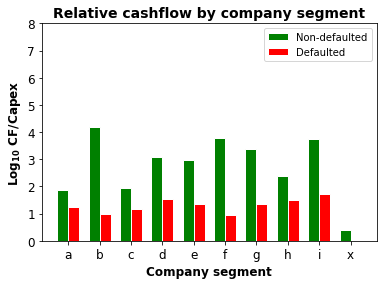

In [18]:
relative_CF_figure(companies, by_segment = False)
relative_CF_figure(companies, by_segment = True)

Calculate $\texttt{CF}/(1+\texttt{CAPEX})$ instead to avoid missingness:

In [19]:
companies['cf/capex'] = companies[('cf', 'sum')]/(1+abs(companies[('capex', 'sum')]))
print('Proportion of missing values: \n'  + str(round(companies.isnull().sum()*100/len(companies), 1)))

Proportion of missing values: 
PCL                   mean            0.0
bad                   pivot_static    0.0
capex                 sum             0.0
cf                    sum             0.0
company_age_segment   pivot_static    0.0
company_segment       pivot_static    0.0
customer_receiver_id  <lambda>        0.0
num_transactions      sum             0.0
pay_delay             mean            4.6
receiver_not_company  mean            0.0
trans_initiated_date  daterange       0.0
transaction_amt       fraud_LR        0.0
                      mean            0.0
cf/capex                              0.0
dtype: float64


With the new definition the variable is not as convincing...

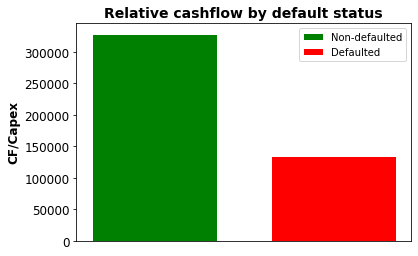

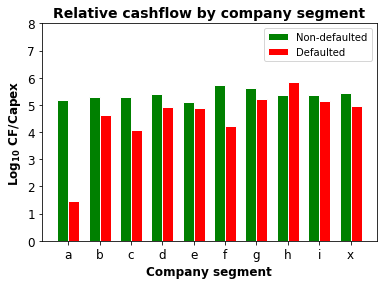

In [20]:
relative_CF_figure(companies, by_segment = False)
relative_CF_figure(companies, by_segment = True)

The Partial & Contested transaction (PCL) variable seems to be a decent predictor of default. It could further be calculated separately by debit/credit.

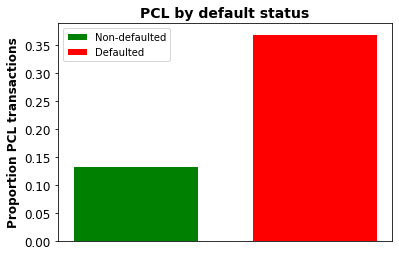

In [21]:
PCL_figure(companies)

A test-function for the fraud LR test returns the distribution of the test statistic under the null and alternative hypotheses:

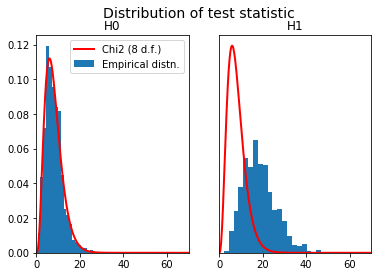

In [24]:
test_fcn_fraud_LR(rep = 1000, sample_size = 200)

However, it seems that the test statistic is unlikely to be useful for predicting defaults with this data set.

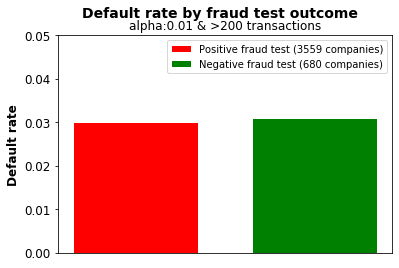

In [25]:
fraud_figure(companies, min_transactions = 200, alpha = 0.01)

Load saved transaction delay trend files (implementation is pretty slow)...

In [28]:
credit_delays = pd.read_csv('credit_delays.csv', index_col=0) 
debit_delays = pd.read_csv('debit_delays.csv', index_col=0) 
all_delays = pd.read_csv('all_delays.csv', index_col=0) 

Merge the delay trend frames with the cross-sectional dataframe

In [29]:
companies_complete = reduce(lambda  left,right: pd.merge(left, right, how='outer', left_index = True, right_index = True), [companies, credit_delays, debit_delays, all_delays])

It seems like good companies have low trend in pay_delays while bad companies typically have negative(!) trend. This is true for both zero-truncated delays and when allowing negative delays.

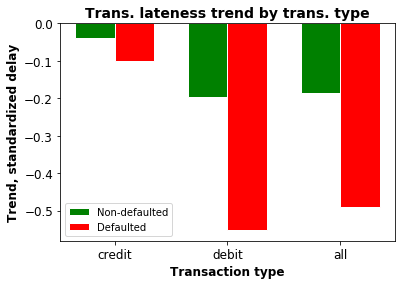

In [30]:
pay_delay_figure(companies_complete)

## Data preparation
Check percent missingness for the cross-sectional data set

In [31]:
print('Proportion of missing values: \n'  + str(round(companies_complete.isnull().sum()*100/len(companies_complete), 1)))

Proportion of missing values: 
(PCL, mean)                             0.0
(bad, pivot_static)                     0.0
(capex, sum)                            0.0
(cf, sum)                               0.0
(company_age_segment, pivot_static)     0.0
(company_segment, pivot_static)         0.0
(customer_receiver_id, <lambda>)        0.0
(num_transactions, sum)                 0.0
(pay_delay, mean)                       4.6
(receiver_not_company, mean)            0.0
(trans_initiated_date, daterange)       0.0
(transaction_amt, fraud_LR)             0.0
(transaction_amt, mean)                 0.0
(cf/capex, )                            0.0
credit_delay_trend                     51.0
debit_delay_trend                      11.8
all_delay_trend                        11.4
dtype: float64


Check percent missingness by default status:

In [32]:
print('Proportion of missing values, defaulted: \n'  + str(round(companies_complete[companies_complete[('bad', 'pivot_static')]  == 1].isnull().sum()*100/len(companies_complete[companies_complete[('bad', 'pivot_static')] == 1]), 1)))
print('Proportion of missing values, not defaulted: \n'  + str(round(companies_complete[companies_complete[('bad', 'pivot_static')]  == 0].isnull().sum()*100/len(companies_complete[companies_complete[('bad', 'pivot_static')] == 0]), 1)))

Proportion of missing values, defaulted: 
(PCL, mean)                             0.0
(bad, pivot_static)                     0.0
(capex, sum)                            0.0
(cf, sum)                               0.0
(company_age_segment, pivot_static)     0.0
(company_segment, pivot_static)         0.0
(customer_receiver_id, <lambda>)        0.0
(num_transactions, sum)                 0.0
(pay_delay, mean)                      10.3
(receiver_not_company, mean)            0.0
(trans_initiated_date, daterange)       0.0
(transaction_amt, fraud_LR)             0.0
(transaction_amt, mean)                 0.0
(cf/capex, )                            0.0
credit_delay_trend                     44.2
debit_delay_trend                      22.4
all_delay_trend                        21.0
dtype: float64
Proportion of missing values, not defaulted: 
(PCL, mean)                             0.0
(bad, pivot_static)                     0.0
(capex, sum)                            0.0
(cf, sum)        

We have considerable missingness for credit_delay_trend. Whats worse is that missingness is likely related to the target variable (default status of company). We probably only need one of the delay trend variables.

We have different number of observed transactions for each user_id and the following transformation is scale-free with regards to transaction history length.

$$\texttt{Transaction_intensity} = \frac{\textrm{total number of transactions}}{\textrm{number of days between first and last initiated transaction}}$$

In [35]:
companies_complete['transaction_intensity'] = companies_complete[('num_transactions','sum')]/(1+companies_complete[('trans_initiated_date', 'daterange')])

Drop variables that have too high missingness or are only used as transformed variables.

In [36]:
companies_model = companies_complete.drop(columns = ['credit_delay_trend', 
                                                     'debit_delay_trend', 
                                                     ('transaction_amt', 'fraud_LR'), 
                                                     ('cf', 'sum'), 
                                                     ('capex', 'sum'), 
                                                     ('num_transactions', 'sum')])

After dropping rows where at least one variable is missing we are left with 15944 observations (out of 18000).

In [37]:
companies_model.dropna(inplace = True)

In the cleaned data set the proportion of bad (defaulted) companies is 3.27 %

In [38]:
np.mean(companies_model[('bad', 'pivot_static')])

0.032739588559959856

Rename columns to more managable names.

In [39]:
companies_model.rename(columns={('PCL', 'mean'): 'PCL',                                    # proportion of PCL transactions
                                ('bad', 'pivot_static'):                 'bad',            # bad, indicator
                                ('company_age_segment', 'pivot_static'): 'age',            # age, categorical
                                ('company_segment', 'pivot_static'):     'segment',        # segment, categorical
                                ('customer_receiver_id', '<lambda>'):    'n_customers',    # number of unique receiver ids
                                ('pay_delay', 'mean'):                   'pay_delay',      # average transaction delay
                                ('receiver_not_company', 'mean'):        'B2C',            # degree of B2C (0-1)
                                ('trans_initiated_date', 'daterange'):   'system_history', # number of days between first and last observed transaction
                                ('transaction_amt', 'mean'):             'avg_trans_size', # average transaction size
                                ('cf/capex', ''):                        'rel_cashflow',   # Relative cashflow
                                'all_delay_trend':                       'delay_trend'},   # Standardized delay trend
                                inplace = True)      # Standardized delay trend

Get dummy variables for age and segment, and check that none of the dummies have zero mean.

In [40]:
companies_model = pd.get_dummies(companies_model, drop_first=True)
np.mean(companies_model)

PCL                           0.077992
bad                           0.032740
n_customers                  34.381711
pay_delay                     6.359440
B2C                           0.180756
system_history              545.445748
avg_trans_size            44034.982943
rel_cashflow             358219.514708
delay_trend                  -0.195099
transaction_intensity         0.428874
age_mature                    0.280607
age_new                       0.180883
age_old                       0.199636
segment_b                     0.026719
segment_c                     0.020321
segment_d                     0.338497
segment_e                     0.052245
segment_f                     0.156109
segment_g                     0.235637
segment_h                     0.098093
segment_i                     0.047792
segment_x                     0.000314
dtype: float64

## Modelling defaults using logistic regression
### Some good old fashioned statistics...

In [42]:
from statsmodels.formula.api import logit
logregmodel = logit('bad ~ 1 + PCL + n_customers'
                   ' + pay_delay + B2C + system_history + avg_trans_size'
                   ' + rel_cashflow + delay_trend + transaction_intensity'
                   ' + age_mature + age_new + age_old + segment_b'
                   ' + segment_c + segment_d + segment_e + segment_f + segment_g'
                   ' + segment_h + segment_i + segment_x', companies_model).fit()
print(logregmodel.summary())

Optimization terminated successfully.
         Current function value: 0.123357
         Iterations 21
                           Logit Regression Results                           
Dep. Variable:                    bad   No. Observations:                15944
Model:                          Logit   Df Residuals:                    15922
Method:                           MLE   Df Model:                           21
Date:                Sun, 20 Dec 2020   Pseudo R-squ.:                  0.1442
Time:                        19:16:48   Log-Likelihood:                -1966.8
converged:                       True   LL-Null:                       -2298.2
Covariance Type:            nonrobust   LLR p-value:                9.845e-127
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.5123      0.364     -6.908      0.000      -3.225      -1

## We can also do some classification
First split data into training (80 %) and testing (20 %) sets using **sklearn** built in function to stratify training and testing data on the dependent variable. 

In [43]:
X  = companies_model.drop('bad', axis = 1, inplace = False)
Y  = companies_model.pop('bad')
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=2, stratify=Y)

Define wrapper function for training a logistic regression classifier using **sklearn**

```python
def logreg_train(X_train, Y_train, X_test, Y_test):
    
    # Create logistic regression model object
    classifier = sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0,
                                            fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                            random_state=None, solver='lbfgs', max_iter=1000, multi_class='auto', 
                                            verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)    
    # Fit classifier using the training data
    classifier.fit(X_train, Y_train)
    return classifier
```

In [44]:
classifier = logreg_train(X_train, Y_train, X_test, Y_test)

Define wrapper function for evaluating the classifier

```python
def eval_classifier(classifier, X_train, Y_train, X_test, Y_test, cutoff):
    # Evaluate on training data
    print('\n-- Training data --')
    decisions = (classifier.predict_proba(X_train) >= cutoff)[:,1].astype(int)
    accuracy = sklearn.metrics.accuracy_score(Y_train, decisions)
    print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
    print('Classification Report:')
    print(sklearn.metrics.classification_report(Y_train, decisions))
    print('Confusion Matrix:')
    print(sklearn.metrics.confusion_matrix(Y_train, decisions))
    print('')
    # Evaluate on test data
    print('\n---- Test data ----')
    decisions = (classifier.predict_proba(X_test) >= cutoff)[:,1].astype(int)
    accuracy = sklearn.metrics.accuracy_score(Y_test, decisions)
    print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
    print('Classification Report:')
    print(sklearn.metrics.classification_report(Y_test, decisions))
    print('Confusion Matrix:')
    print(sklearn.metrics.confusion_matrix(Y_test, decisions))
    print('Coefficients:')
    coefs = pd.DataFrame(data = classifier.coef_, columns = list(X_train.columns))
    print(coefs)
```

Evaluate precision, recall (specificity) and get confusion matrices for training and testing data using some probability cutoff for classifying bad companies.

In [45]:
eval_classifier(classifier, X_train, Y_train, X_test, Y_test, cutoff = 0.05)


-- Training data --
Accuracy: 71.89
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     12337
         1.0       0.06      0.56      0.11       418

    accuracy                           0.72     12755
   macro avg       0.52      0.64      0.47     12755
weighted avg       0.95      0.72      0.81     12755

Confusion Matrix:
[[8938 3399]
 [ 186  232]]


---- Test data ----
Accuracy: 71.62
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83      3085
         1.0       0.06      0.52      0.11       104

    accuracy                           0.72      3189
   macro avg       0.52      0.62      0.47      3189
weighted avg       0.95      0.72      0.81      3189

Confusion Matrix:
[[2230  855]
 [  50   54]]
Coefficients:
            PCL  n_customers  pay_delay       B2C  system_history  \
0 -2.524854e-07    -0.000639  -0.000073 -0.000003   